In [13]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
import scrapbook as sb

In [14]:
token = 'ETH'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///data/data.db'

In [15]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [16]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [17]:
prices['volatility'] = vol_ohlc(prices,2)


In [18]:
prices['return']=np.log(prices['close']/prices['open'])

In [19]:
prices['drawdown']=(prices.high-prices.low)/prices.high
prices['max_drawdown']=prices['drawdown'].expanding().max()

In [20]:
def series_plot(data, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)



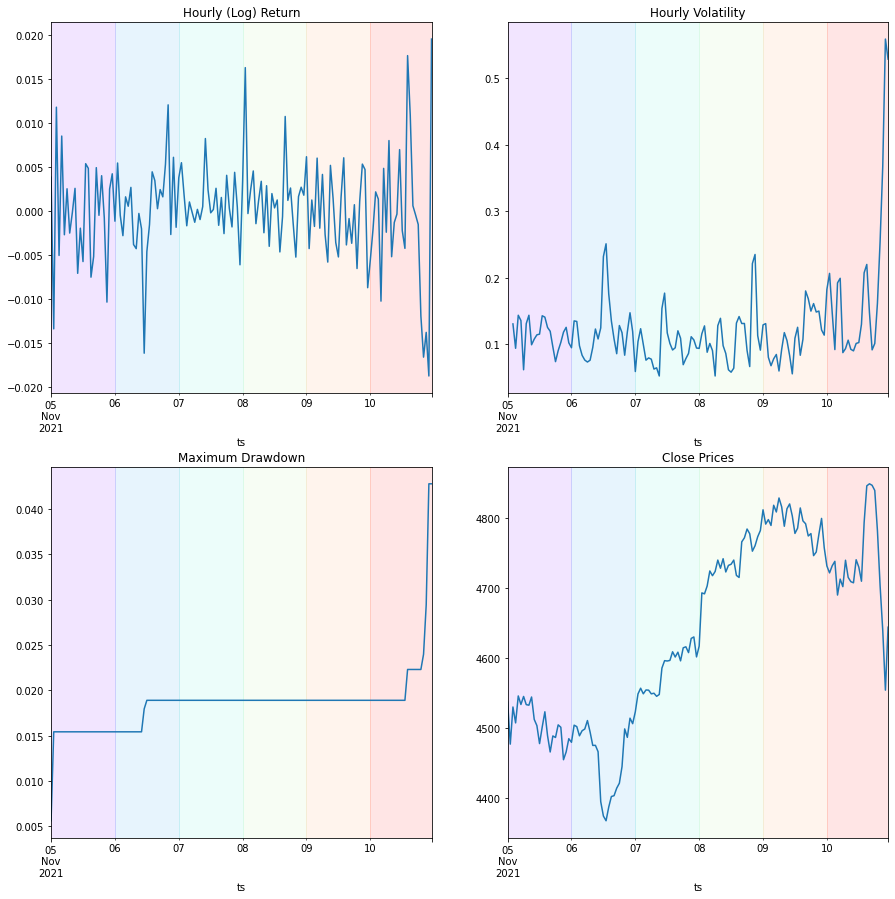

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

series_plot(prices['return'],ax=ax[0,0])
ax[0,0].title.set_text('Hourly (Log) Return')

series_plot(prices['volatility'],ax=ax[0,1])
ax[0,1].title.set_text('Hourly Volatility')

series_plot(prices['max_drawdown'],ax=ax[1,0])
ax[1,0].title.set_text('Maximum Drawdown')

series_plot(prices['close'],ax=ax[1,1])
ax[1,1].title.set_text('Close Prices')


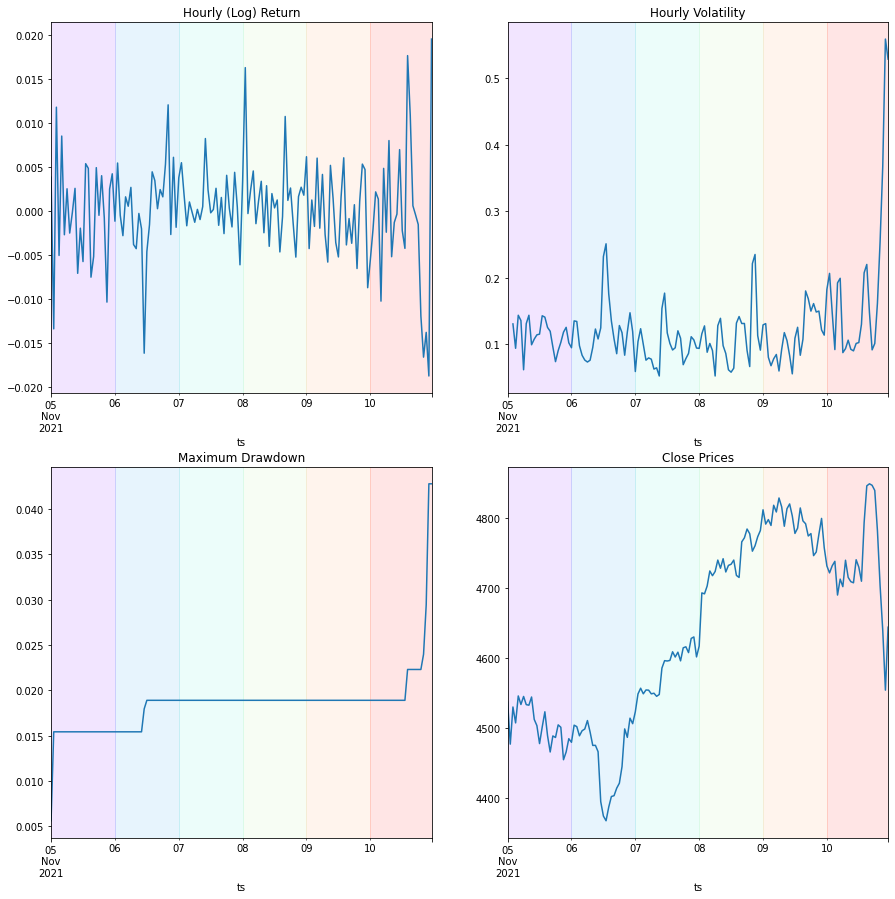

In [24]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)

In [25]:
prices

,open,high,low,close,volume,volumeUSD,token,chain,volatility,return,drawdown,max_drawdown
ts,,,,,,,,,,,,
2021-11-05 00:00:00,4519.73,4540.16,4514.69,4537.15,6492.325881,2.943114e+07,ETH,ETH,NaN,0.003847,0.005610,0.005610
2021-11-05 01:00:00,4537.14,4540.00,4470.00,4476.85,8510.556564,3.836379e+07,ETH,ETH,NaN,-0.013377,0.015419,0.015419
2021-11-05 02:00:00,4476.85,4530.77,4472.43,4529.95,6533.914754,2.940356e+07,ETH,ETH,0.130637,0.011791,0.012876,0.015419
2021-11-05 03:00:00,4529.98,4536.47,4507.20,4507.20,7570.622899,3.425757e+07,ETH,ETH,0.093982,-0.005041,0.006452,0.015419
2021-11-05 04:00:00,4507.19,4569.42,4507.19,4545.73,8138.258467,3.695421e+07,ETH,ETH,0.143659,0.008514,0.013619,0.015419
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10 19:00:00,4839.52,4840.58,4760.00,4782.18,14132.762822,6.784813e+07,ETH,ETH,0.161734,-0.011919,0.016647,0.022296
2021-11-10 20:00:00,4782.18,4809.28,4694.00,4703.51,13968.314420,6.635433e+07,ETH,ETH,0.254322,-0.016587,0.023970,0.023970
2021-11-10 21:00:00,4703.75,4723.98,4585.00,4639.39,28701.711301,1.340541e+08,ETH,ETH,0.367605,-0.013777,0.029420,0.029420
